In [ ]:
# 拡散モデルによる
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
from tqdm import tqdm

# ハイパーパラメータ
num_timesteps = 1000 # 拡散ステップ数
epochs = 10          # 学習エポック数
lr = 1e-3            # 学習率
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# 時間埋め込み（正弦波位置エンコーディング）
def pos_encoding(timesteps, output_dim, device='cpu'):
    batch_size = len(timesteps)
    v = torch.zeros(batch_size, output_dim, device=device)
    for i in range(batch_size):
        for j in range(output_dim // 2):
            omega = 1.0 / (10000 ** (2 * j / output_dim))
            v[i, 2 * j] = torch.sin(timesteps[i] * omega)
            v[i, 2 * j + 1] = torch.cos(timesteps[i] * omega)
    return v

# 拡散モデル
class DiffusionModel(nn.Module):
    def __init__(self, time_embed_dim=16):
        super(DiffusionModel, self).__init__()
        self.time_embed_dim = time_embed_dim
        self.fc1 = nn.Linear(1 + time_embed_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x, t):
        # 時間埋め込み
        t_embed = pos_encoding(t, self.time_embed_dim, x.device)
        x_t = torch.cat([x, t_embed], dim=1)  # 時間情報と入力データを結合
        x_t = F.relu(self.fc1(x_t))
        x_t = F.relu(self.fc2(x_t))
        return self.fc3(x_t)

# 拡散プロセス
class Diffuser:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02, device='cpu'):
        self.num_timesteps = num_timesteps
        self.device = device
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps, device=device)
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def add_noise(self, x_0, t):
        t_idx = t - 1 # alphas[0] is for t=1
        alpha_bar = self.alpha_bars[t_idx].view(-1, 1)  # (N, 1)
        noise = torch.randn_like(x_0, device=self.device)
        x_t = torch.sqrt(alpha_bar) * x_0 + torch.sqrt(1 - alpha_bar) * noise
        return x_t, noise

    def denoise(self, model, x, t):
        T = self.num_timesteps
        assert (t >= 1).all() and (t <= T).all()
        
        t_idx = t - 1 # alphas[0] is for t=1
        alpha = self.alphas[t_idx].view(-1, 1)
        alpha_bar = self.alpha_bars[t_idx].view(-1, 1)
        model.eval()
        with torch.no_grad():
            eps = model(x, t)

        noise = torch.randn_like(x, device=self.device)
        noise[t == 1] = 0  # no noise at t=1

        mu = (x - (1 - alpha) / torch.sqrt(1 - alpha_bar) * eps) / torch.sqrt(alpha)

        return mu

# モデルとオプティマイザ
time_embed_dim = 16
model = DiffusionModel(time_embed_dim=time_embed_dim).to(device)
optimizer = Adam(model.parameters(), lr=lr)
diffuser = Diffuser(num_timesteps=num_timesteps, device=device)


Train Data: [10.94287033  7.61804861 12.86541394  9.37469621  8.55882253 11.77432588
 11.71917683  8.72695299 10.03139274  5.51463009 12.30007145 11.98389204
 11.90664826  5.95749036  9.33184527 10.00423673 10.81090682 10.57818388
 12.64231638  6.90618889  9.59470735  8.68806131 10.38684275 11.10687782
 12.63630311  9.06138943 11.35110817  6.36594555  9.63378292 12.11793838
  9.20431954 10.67487531 12.09515715 12.09187651 11.72743458  9.75581685
 10.24942591  9.35441039 11.68334943 14.78192103 10.15239918  8.86710814
 10.07228387  5.8500448  10.4955844   8.20568643  9.72641033 10.03657838
 11.51082796 10.43053716 11.68201759  7.10837985  7.19605344  9.7981636
  8.9035151   9.71076098 10.70804066  9.92897395 11.13147661 13.09131761
  8.05152733  9.85931025 10.61593771  9.58300247 12.06760147  5.19909273
 14.06120724  7.71473742 10.42376677 11.40944125  8.42912958 10.92411947
 11.40845645 11.04701594  8.14749137 14.0156859  10.45392508  7.69468178
 11.26395889 10.07902537 10.92878465  2.

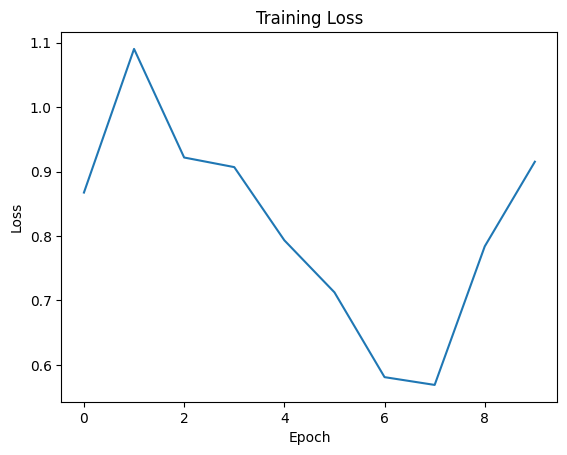

Generated Samples: [ 23.137568   90.30057    83.26166    33.790634  145.69221    41.522343
  51.34917    12.438725   28.113438   81.136024    9.514162   21.514137
   6.3036537  97.807365    8.506497  113.12403    17.155615    9.220087
  12.53037    64.325554    7.130076  143.93388   173.79736    13.97167
  41.813564   57.74201    23.344072   13.518108    7.792415   71.374245
  47.607723    8.723421   22.51149     7.1265626 116.70438    88.809006
  35.77888    59.832714   82.38361     6.638557   47.23747    31.038918
 244.73169    69.52078    32.490585   55.59215    97.3802      7.204517
  12.451552  231.57397  ]


In [7]:
# シードの固定
np.random.seed(1234)

# 正規乱数のパラメータの設定
mean = 10 # 平均
var = 4 # 分散
std = np.sqrt(var) # 標準偏差

# 学習データ(randn: 正規分布)
data = np.random.normal(mean, std, 100)
# print("Train Data:", data)
train_data = torch.tensor(data, dtype=torch.float32).view(-1, 1).to(device)  # shape: (100, 1)


# データローダー作成
batch_size = 10
dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# 学習ループ
losses = []
for epoch in range(epochs):
    loss_sum = 0.0
    for batch in dataloader:
        optimizer.zero_grad()
        x = batch.to(device)
        t = torch.randint(1, num_timesteps + 1, (len(x),), device=device)

        x_noisy, noise = diffuser.add_noise(x, t)
        noise_pred = model(x_noisy, t)
        loss = F.mse_loss(noise_pred, noise)

        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
    avg_loss = loss_sum / len(dataloader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss}")

# 学習曲線のプロット
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


# サンプリング
model.eval()
with torch.no_grad():
    samples = torch.randn((50, 1), device=device)  # ランダムなノイズから開始
    for t in range(num_timesteps, 0, -1):
        t_tensor = torch.tensor([t] * len(samples), device=device)
        samples = diffuser.denoise(model, samples, t_tensor)

Text(0.5, 1.0, 'Train Data Distribution')

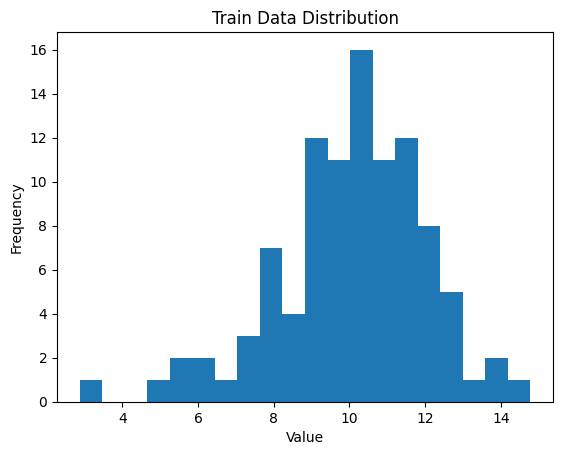

In [8]:
# 学習データの図示
plt.hist(data, bins=20)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Train Data Distribution')

Generated Samples: [ 23.137568   90.30057    83.26166    33.790634  145.69221    41.522343
  51.34917    12.438725   28.113438   81.136024    9.514162   21.514137
   6.3036537  97.807365    8.506497  113.12403    17.155615    9.220087
  12.53037    64.325554    7.130076  143.93388   173.79736    13.97167
  41.813564   57.74201    23.344072   13.518108    7.792415   71.374245
  47.607723    8.723421   22.51149     7.1265626 116.70438    88.809006
  35.77888    59.832714   82.38361     6.638557   47.23747    31.038918
 244.73169    69.52078    32.490585   55.59215    97.3802      7.204517
  12.451552  231.57397  ]


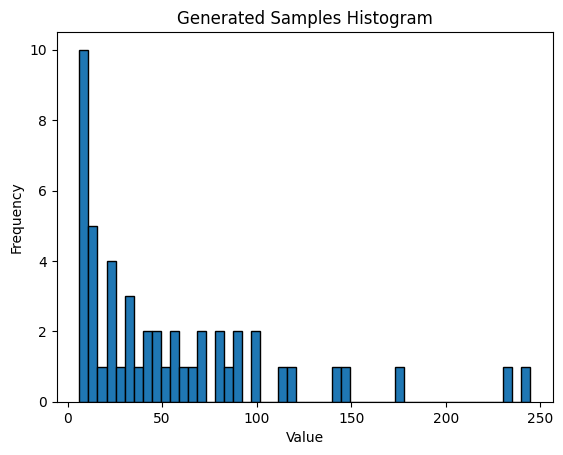

In [11]:
# サンプル結果の表示
print("Generated Samples:", samples.cpu().numpy().flatten())

# サンプル結果のプロット
plt.hist(samples.cpu().numpy().flatten(), bins=50, edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Generated Samples Histogram')
plt.show()